# MS-Glance + SIREN

This is a colab showing how to use MS-Glance (WACV submission) based  on Siren: [Implicit Neural Activations with Periodic Activation Functions](https://vsitzmann.github.io/siren).


In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt

import time

def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

In [2]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.

    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a
    # hyperparameter.

    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)

    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first

        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)

        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features,
                                             1 / self.in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0,
                                             np.sqrt(6 / self.in_features) / self.omega_0)

    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))

    def forward_with_intermediate(self, input):
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate


class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False,
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()

        self.net = []
        self.net.append(SineLayer(in_features, hidden_features,
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features,
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)

            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0,
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)

            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features,
                                      is_first=False, omega_0=hidden_omega_0))

        self.net = nn.Sequential(*self.net)

    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)

                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()

                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else:
                x = layer(x)

                if retain_grad:
                    x.retain_grad()

            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

And finally, differential operators that allow us to leverage autograd to compute gradients, the laplacian, etc.

In [3]:
def laplace(y, x):
    grad = gradient(y, x)
    return divergence(grad, x)


def divergence(y, x):
    div = 0.
    for i in range(y.shape[-1]):
        div += torch.autograd.grad(y[..., i], x, torch.ones_like(y[..., i]), create_graph=True)[0][..., i:i+1]
    return div


def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad

# Experiments

For the image fitting experiments, we'll use the classic [astronaunt image](https://scikit-image.org/docs/stable/api/skimage.data.html#skimage.data.astronaut).

In [4]:
def get_astronaut_tensor(sidelength):
    img = Image.fromarray(skimage.data.astronaut())
    transform = Compose([
        Resize(sidelength),
        ToTensor(),
    ])
    img = transform(img)
    return img

In [5]:
class ImageFitting(Dataset):
    def __init__(self, sidelength):
        super().__init__()
        img = get_astronaut_tensor(sidelength)
        # print(img.shape)
        self.pixels = img.permute(1, 2, 0).view(-1, 3)
        self.coords = get_mgrid(sidelength, 2)

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        if idx > 0: raise IndexError

        return self.coords, self.pixels

Let's instantiate the dataset and our Siren. As pixel coordinates are 2D, the siren has 2 input features, and since the image is RGB, it has three output channel.

In [6]:
astronaut = ImageFitting(512)
dataloader = DataLoader(astronaut, batch_size=1, pin_memory=True, num_workers=0)


/usr/local/lib/python3.10/dist-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Now we show how to construct Global Glance Vectors.

In [7]:
def random_sampling_shared(tensor1, tensor2, sample_height, sample_width, threshold=-0.01):
    mask = tensor2 > threshold
    batch_size, channels, height, width = tensor1.size()
    num_samples = sample_height * sample_width

    valid_points = mask.sum(dim=(1, 2))

    sampled_tensor1 = torch.zeros(
        (batch_size, channels, sample_height, sample_width), dtype=tensor1.dtype, device=tensor1.device
    )
    sampled_tensor2 = torch.zeros(
        (batch_size, channels, sample_height, sample_width), dtype=tensor2.dtype, device=tensor2.device
    )

    for i in range(batch_size):
        valid_indices = torch.nonzero(mask[i,0].view(-1), as_tuple=False)  # Get linear indices of valid points
        valid_indices = valid_indices.squeeze()  # Ensure it is a 1D tensor

        if valid_indices.numel() < num_samples:
            print(f"Batch {i} does not have enough valid points to sample from.")
            break

        # Randomly choose indices from valid points
        chosen_indices = valid_indices[torch.randperm(valid_indices.numel())[:num_samples]]

        # Convert chosen indices to row and column indices
        rows = chosen_indices // width
        cols = chosen_indices % width

        # Ensure indices are within bounds
        if torch.any(rows >= height) or torch.any(cols >= width):
            # raise ValueError("Chosen indices are out of bounds.")
            print(rows, height, width, "Chosen indices are out of bounds.")
            break


        # Sample tensor1 and tensor2 based on the chosen indices
        sampled_tensor1[i] = tensor1[i, :, rows, cols].view(channels, sample_height, sample_width)
        sampled_tensor2[i] = tensor2[i, :, rows, cols].view(channels, sample_height, sample_width)

    return sampled_tensor1, sampled_tensor2

In [9]:
import torch
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim_metric
from skimage.metrics import peak_signal_noise_ratio as psnr
import math

from MSGlance.Global import GlobalGlance
GlobalGlance = GlobalGlance(kernel_size=16, patch_height=96, patch_width=96, stride=1, drop="LC")

from MSGlance.Local import LocalGlance
LocalGlance = LocalGlance(window_size=16, stride=1, channel=1, drop="LC")

total_steps = 501
steps_til_summary = 50
plot_steps = [0,5,10,20,30,40,50,100,200,300,400,500]


for model_input, ground_truth in dataloader:
    img_siren = Siren(in_features=2, out_features=3, hidden_features=256,
                      hidden_layers=3, outermost_linear=True)
    img_siren.cuda()
    optim = torch.optim.Adam(lr=1e-4, params=img_siren.parameters())
    model_input, ground_truth = model_input.cuda(), ground_truth.cuda()
    psnr_i = 0
    ssim_i = 0

    output_images = []
    error_maps = []
    ssim_maps = []
    psnr_values_Global_glance = []
    ssim_values_Global_glance = []

    for step in range(total_steps):
        model_output, coords = img_siren(model_input)
        patch_recon, patch_tar = random_sampling_shared(model_output.view(1,3,512,512), ground_truth.view(1,3,512,512), 96, 96)
        loss_global = GlobalGlance(patch_recon, patch_tar)
        loss = ((model_output - ground_truth)**2).mean() + 0.01*loss_global + 0.01*(1-LocalGlance(model_output.view(1,3,512,512), ground_truth.view(1,3,512,512)))
        optim.zero_grad()
        loss.backward(retain_graph=True)
        torch.nn.utils.clip_grad_norm_(img_siren.parameters(), max_norm=1.0)
        optim.step()

        if step in plot_steps:
            model_output_img = model_output.cpu().view(512, 512, 3).detach().numpy()
            ground_truth_img = ground_truth.cpu().view(512, 512, 3).detach().numpy()
            error_map = (model_output_img - ground_truth_img)**2

            ssim_value, ssim_map = ssim_metric(
                ground_truth_img,
                model_output_img,
                data_range=ground_truth_img.max() - ground_truth_img.min(),
                multichannel=True,
                channel_axis=-1,
                full=True
            )
            psnr_value = psnr(ground_truth_img, model_output_img, data_range=ground_truth_img.max() - ground_truth_img.min())
            print("Step", step, psnr_value, ssim_value)
            output_images.append(model_output_img)
            error_maps.append(error_map)
            ssim_maps.append(ssim_map)
            psnr_values_Global_glance.append(psnr_value)
            ssim_values_Global_glance.append(ssim_value)

Step 0 5.026742214814832 -0.010588616
Step 5 9.693028752393662 0.28719112
Step 10 11.779427465746746 0.33737144
Step 20 16.918874872344215 0.43157876
Step 30 19.207200656116097 0.48944953
Step 40 20.404629570353173 0.5375266
Step 50 21.207644894208105 0.5734135
Step 100 23.422012919459156 0.68393016
Step 200 25.930018357856387 0.78643674
Step 300 27.775137620890394 0.84480286
Step 400 29.037031572937426 0.87638086
Step 500 30.029890774269916 0.8960188


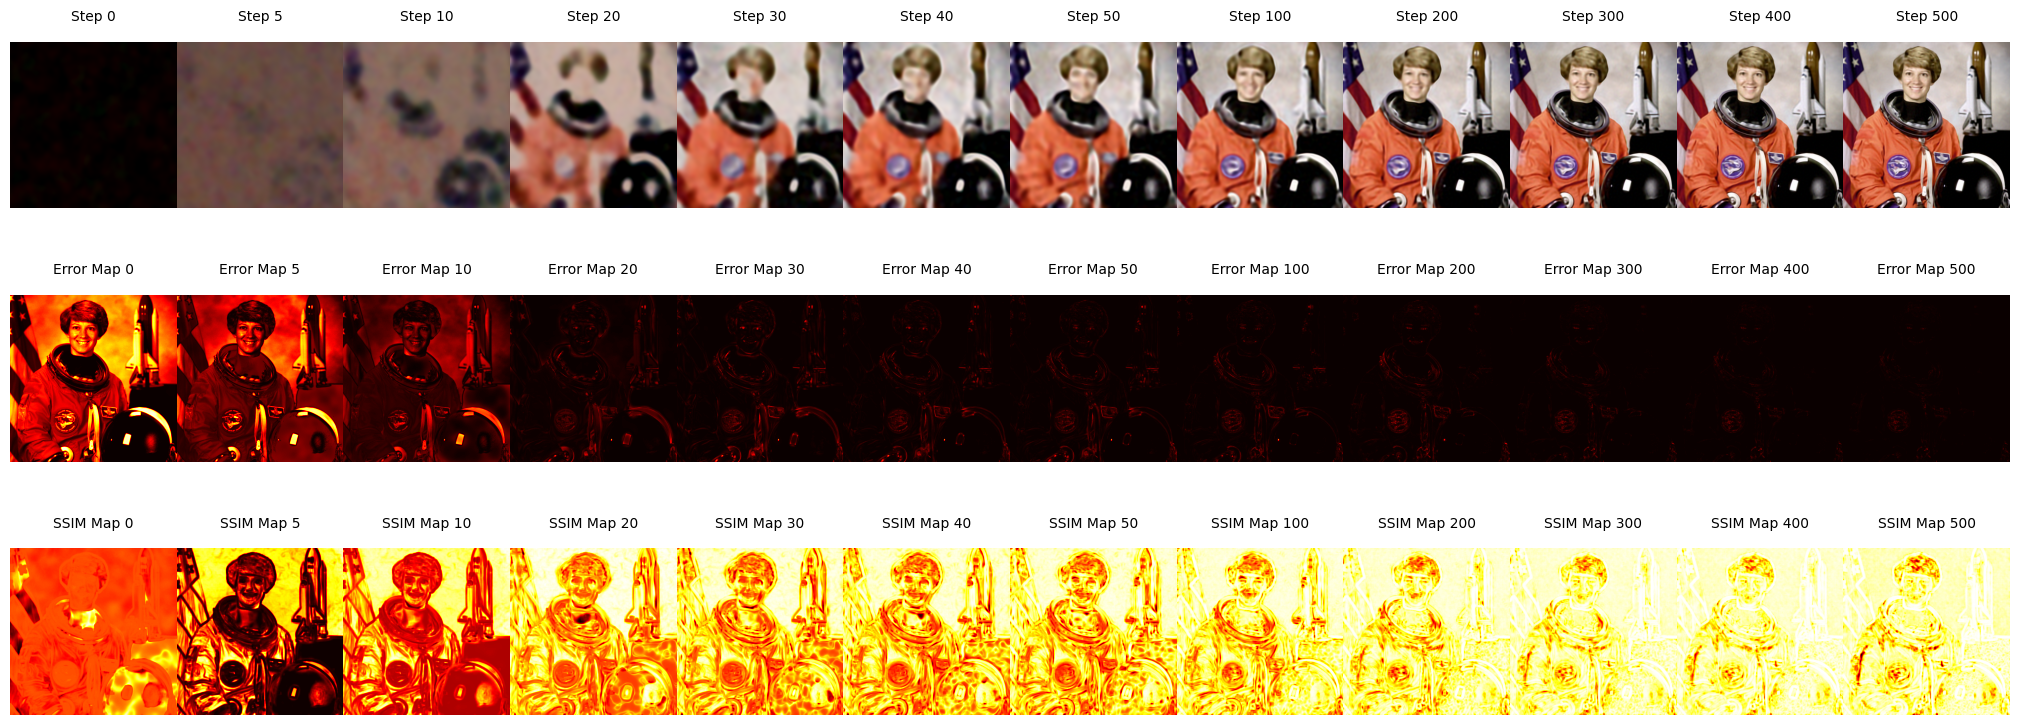

In [10]:
# Visualize step-by-step
fig, axs = plt.subplots(3, len(output_images), figsize=(20, 8))

for i, img in enumerate(output_images):
    axs[0, i].imshow(img)
    axs[0, i].set_title(f'Step {plot_steps[i]}', fontsize=10, pad=15)
    axs[0, i].axis('off')

for i, err in enumerate(error_maps):
    axs[1, i].imshow(err.mean(axis=-1), cmap="hot")
    axs[1, i].set_title(f'Error Map {plot_steps[i]}', fontsize=10, pad=15)
    axs[1, i].axis('off')

for i, ssim_map in enumerate(ssim_maps):
    axs[2, i].imshow(ssim_map.mean(axis=-1), cmap="hot")
    axs[2, i].set_title(f'SSIM Map {plot_steps[i]}', fontsize=10, pad=15)
    axs[2, i].axis('off')

plt.tight_layout(pad=0)
plt.show()

Here is the training process of the original SIREN.

In [11]:
# Original SIREN for comparison
import torch
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim_metric
from skimage.metrics import peak_signal_noise_ratio as psnr
import math


total_steps = 501
steps_til_summary = 50
plot_steps = [0,5,10,20,30,40,50,100,200,300,400,500]


for model_input, ground_truth in dataloader:
    img_siren = Siren(in_features=2, out_features=3, hidden_features=256,
                      hidden_layers=3, outermost_linear=True)
    img_siren.cuda()
    optim = torch.optim.Adam(lr=1e-4, params=img_siren.parameters())
    model_input, ground_truth = model_input.cuda(), ground_truth.cuda()
    psnr_i = 0
    ssim_i = 0

    output_images = []
    error_maps = []
    ssim_maps = []
    psnr_values = []
    ssim_values = []

    for step in range(total_steps):
        model_output, coords = img_siren(model_input)
        loss = ((model_output - ground_truth)**2).mean()
        optim.zero_grad()
        loss.backward(retain_graph=True)
        torch.nn.utils.clip_grad_norm_(img_siren.parameters(), max_norm=1.0)
        optim.step()

        if step in plot_steps:
            model_output_img = model_output.cpu().view(512, 512, 3).detach().numpy()
            ground_truth_img = ground_truth.cpu().view(512, 512, 3).detach().numpy()
            error_map = (model_output_img - ground_truth_img)**2

            ssim_value, ssim_map = ssim_metric(
                ground_truth_img,
                model_output_img,
                data_range=ground_truth_img.max() - ground_truth_img.min(),
                multichannel=True,
                channel_axis=-1,
                full=True
            )
            psnr_value = psnr(ground_truth_img, model_output_img, data_range=ground_truth_img.max() - ground_truth_img.min())
            print("Step", step, psnr_value, ssim_value)
            output_images.append(model_output_img)
            error_maps.append(error_map)
            ssim_maps.append(ssim_map)
            psnr_values.append(psnr_value)
            psnr_values.append(ssim_value)

Step 0 5.224613480579743 0.064976394
Step 5 9.543786645936294 0.2824463
Step 10 11.196497997852665 0.32339168
Step 20 16.362466274272048 0.41677403
Step 30 18.744082436216324 0.46634927
Step 40 19.995154771899706 0.5226944
Step 50 20.846497157235092 0.55729586
Step 100 23.08847543102292 0.6671954
Step 200 25.499949699707173 0.7711599
Step 300 27.245160676498713 0.8296666
Step 400 28.532445533897317 0.86556226
Step 500 29.552052282590857 0.8882654


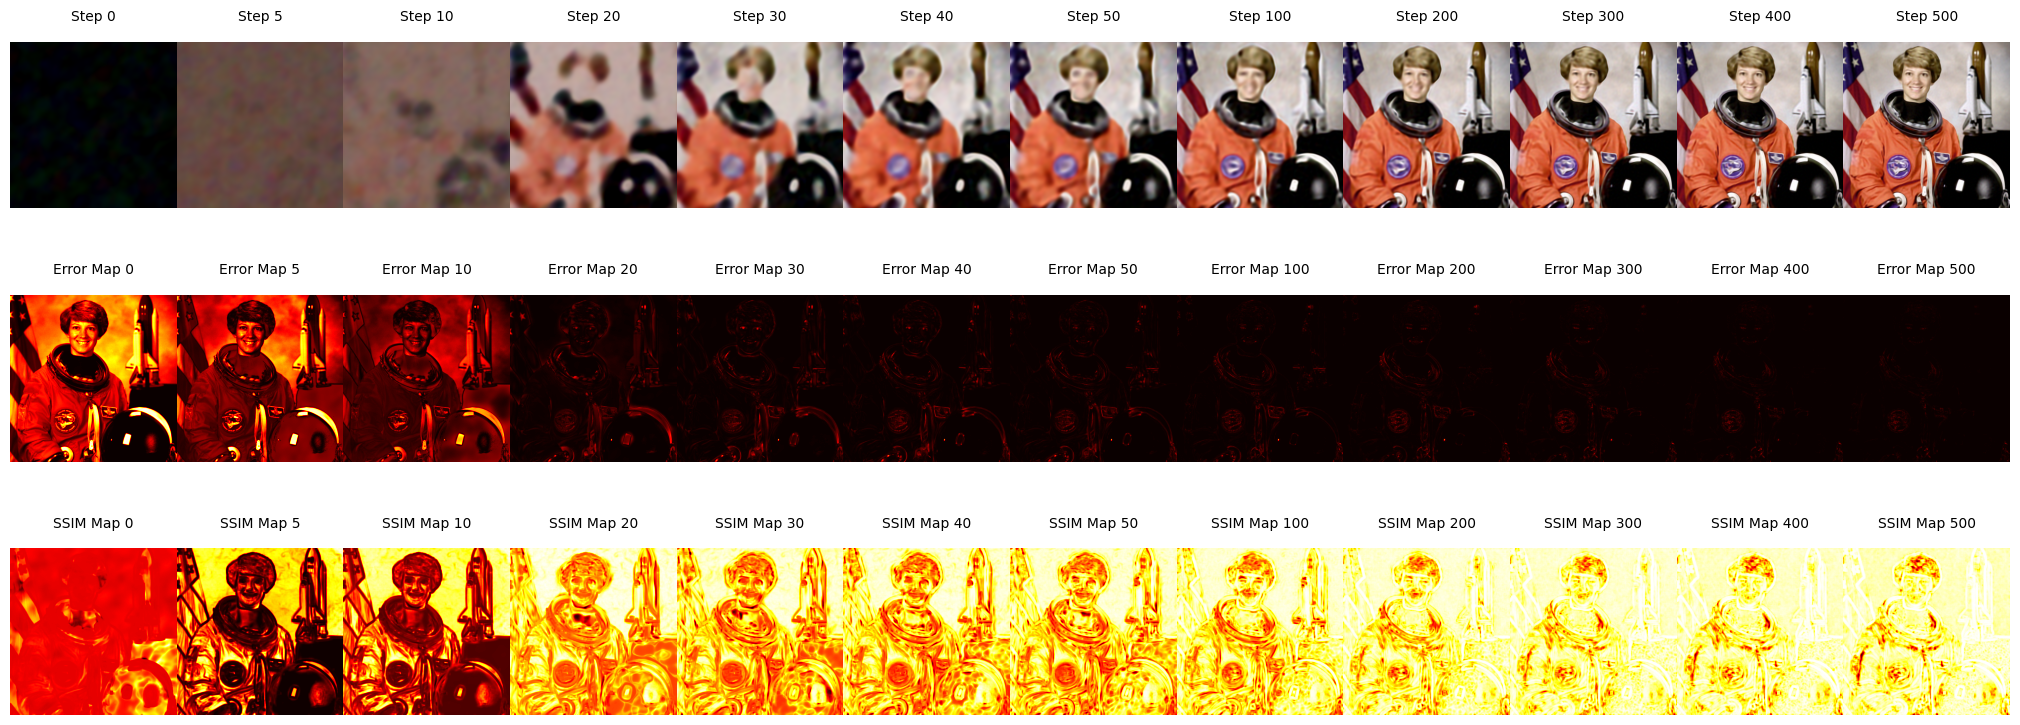

In [12]:
# Visualize step-by-step
fig, axs = plt.subplots(3, len(output_images), figsize=(20, 8))

for i, img in enumerate(output_images):
    axs[0, i].imshow(img)
    axs[0, i].set_title(f'Step {plot_steps[i]}', fontsize=10, pad=15)
    axs[0, i].axis('off')

for i, err in enumerate(error_maps):
    axs[1, i].imshow(err.mean(axis=-1), cmap="hot")
    axs[1, i].set_title(f'Error Map {plot_steps[i]}', fontsize=10, pad=15)
    axs[1, i].axis('off')

for i, ssim_map in enumerate(ssim_maps):
    axs[2, i].imshow(ssim_map.mean(axis=-1), cmap="hot")
    axs[2, i].set_title(f'SSIM Map {plot_steps[i]}', fontsize=10, pad=15)
    axs[2, i].axis('off')

plt.tight_layout(pad=0)
plt.show()